In [97]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import text_normalizer as tn
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import tqdm
from utils import model_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
development = True
if development:
    %matplotlib notebook
else:
    %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 - Load the cleaned dataset
Load the cleaned dataset and split into train and test sets.

In [99]:
data_df = pd.read_csv('dataset_merged_cleaned.csv')
train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(data_df['reviews_clean']), np.array(data_df['labels']),
                                                       np.array(data_df['labels_name']), test_size=0.33, random_state=42)

Show the proportion of the classes (in this case we already know that the dataset is for binary classfication and perfectly balanced).

In [100]:
from collections import Counter

trd = dict(Counter(train_label_names))
tsd = dict(Counter(test_label_names))

(pd.DataFrame([[key, trd[key], tsd[key]] for key in trd], columns=['Target Label', 'Train Count', 'Test Count']).sort_values(by=['Train Count', 'Test Count'],
             ascending=False))

,Target Label,Train Count,Test Count
0,Bad,1008,492
1,Good,1000,498


# 2 - Frequency Models
## 2.1 - Bag of Wrods model

In [107]:
# Build Bag Of Words on cleaned dataset
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0) # SPIEGARE UN Po' i parametri
cv_train_features = cv.fit_transform(train_corpus)
cv_test_features = cv.transform(test_corpus)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('Top 50 words count in the training set:')
top_bow,_,_ = tn.get_top_n_words(train_corpus, n=50, vec=cv, bag_of_words=cv_train_features)
top_bow

BOW model:> Train features shape: (2008, 3665)  Test features shape: (990, 3665)
Top 50 words count in the training set:


[('thi', 426),
 ('wa', 408),
 ('not', 368),
 ('veri', 179),
 ('good', 155),
 ('great', 136),
 ('film', 122),
 ('phone', 114),
 ('movi', 111),
 ('food', 95),
 ('one', 92),
 ('like', 89),
 ('time', 85),
 ('would', 82),
 ('place', 81),
 ('work', 78),
 ('ha', 68),
 ('bad', 66),
 ('love', 64),
 ('well', 61),
 ('go', 61),
 ('ever', 59),
 ('realli', 58),
 ('onli', 57),
 ('best', 55),
 ('no', 55),
 ('use', 53),
 ('could', 52),
 ('get', 52),
 ('back', 50),
 ('even', 49),
 ('also', 47),
 ('made', 46),
 ('look', 42),
 ('much', 40),
 ('product', 40),
 ('qualiti', 40),
 ('ani', 39),
 ('make', 39),
 ('servic', 38),
 ('sound', 38),
 ('better', 36),
 ('watch', 36),
 ('becaus', 36),
 ('never', 36),
 ('hi', 35),
 ('headset', 35),
 ('nice', 34),
 ('think', 34),
 ('price', 33)]

## 2.2 - TF-IDF model

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)
tv_test_features = tv.transform(test_corpus)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)
print('Top 50 words tf-idf in the training set:')
top_bow,_,_ = tn.get_top_n_words(train_corpus, n=50, vec=tv, bag_of_words=tv_train_features)
top_bow

TFIDF model:> Train features shape: (2008, 3665)  Test features shape: (990, 3665)
Top 50 words tf-idf in the training set:


[('wa', 74.92665229420369),
 ('thi', 74.91307477974334),
 ('not', 73.40975746231842),
 ('great', 46.527568862938395),
 ('good', 44.44234330553353),
 ('veri', 44.25524202644922),
 ('phone', 32.09880257655136),
 ('food', 29.233502537308524),
 ('film', 28.441618636266035),
 ('work', 27.070302138413112),
 ('movi', 26.429875061400235),
 ('place', 23.998678595681948),
 ('time', 23.374947885798598),
 ('like', 22.933237636628053),
 ('one', 22.465424167272847),
 ('would', 21.823887611566082),
 ('bad', 21.213477408549966),
 ('love', 20.61013724313999),
 ('back', 20.35380237284827),
 ('go', 19.11324470254326),
 ('realli', 18.132124306399803),
 ('ha', 18.09115884522013),
 ('well', 17.586259636215388),
 ('product', 16.91217380418252),
 ('best', 16.741121764531297),
 ('ever', 16.64937209653166),
 ('servic', 15.4155557596206),
 ('no', 14.725015201773346),
 ('onli', 14.680324436658076),
 ('get', 14.469195568239877),
 ('use', 14.280244835245988),
 ('could', 14.184056179580937),
 ('service', 14.00413414

## 2.3 - Naive Bayes Classifier (raw test only)

### 2.3.1 Test on Bag Of Words

CV Accuracy (5-fold): [0.80099502 0.79104478 0.79353234 0.80049875 0.77057357]
Mean CV Accuracy: 0.7913288917010954


<IPython.core.display.Javascript object>


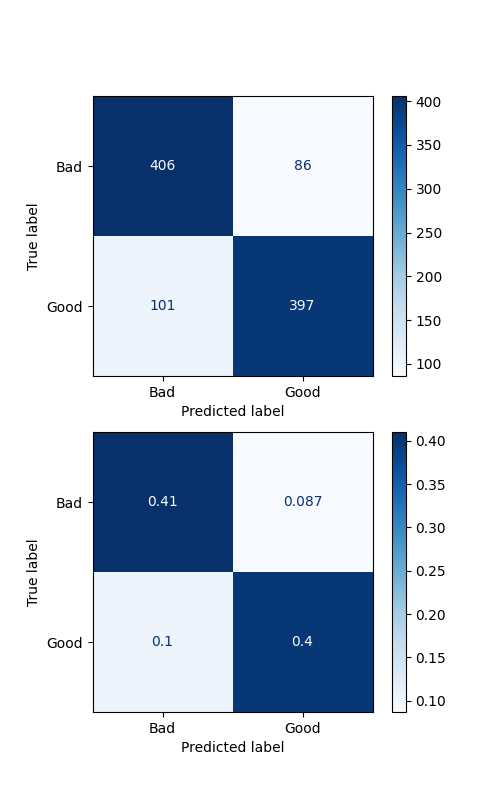

Precision = 0.81, Recall = 0.81, F1 = 0.81, Acc. = 0.81, Bal Acc. = 0.81


In [123]:
mnb = MultinomialNB(alpha=1)
mnb.fit(cv_train_features, train_label_names)
mnb_bow_cv_scores = cross_val_score(mnb, cv_train_features, train_label_names, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
_ = model_eval(test_label_names, cv_test_features, model=mnb, plot_matrix = True, scoring_strategy='micro')

### 2.3.2 Test on TF-IDF

CV Accuracy (5-fold): [0.79850746 0.79104478 0.79850746 0.78802993 0.77057357]
Mean CV Accuracy: 0.7893326385528716


<IPython.core.display.Javascript object>


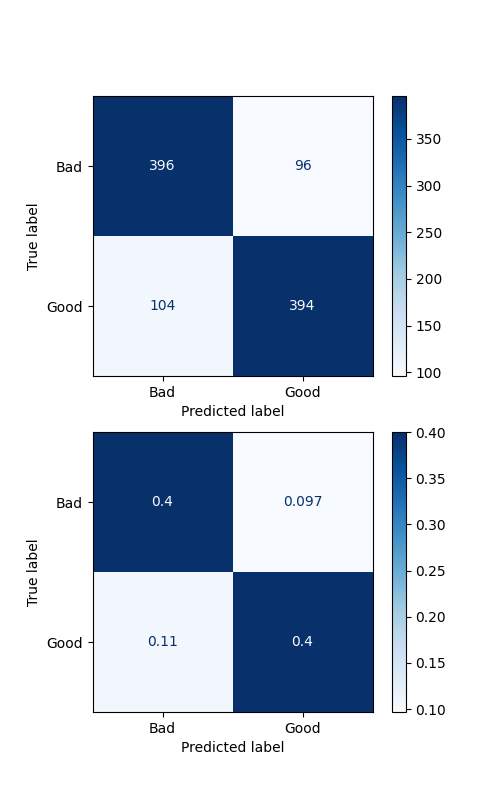

Precision = 0.80, Recall = 0.80, F1 = 0.80, Acc. = 0.80, Bal Acc. = 0.80


In [125]:
mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, train_label_names)
mnb_bow_tv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv=5)
mnb_bow_tv_mean_score = np.mean(mnb_bow_tv_scores)
print('CV Accuracy (5-fold):', mnb_bow_tv_scores)
print('Mean CV Accuracy:', mnb_bow_tv_mean_score)
_ = model_eval(test_label_names, tv_test_features, model=mnb, plot_matrix = True, scoring_strategy='micro')

# 3 - Classifier

### 3.1 - Build the pipeline

<IPython.core.display.Javascript object>


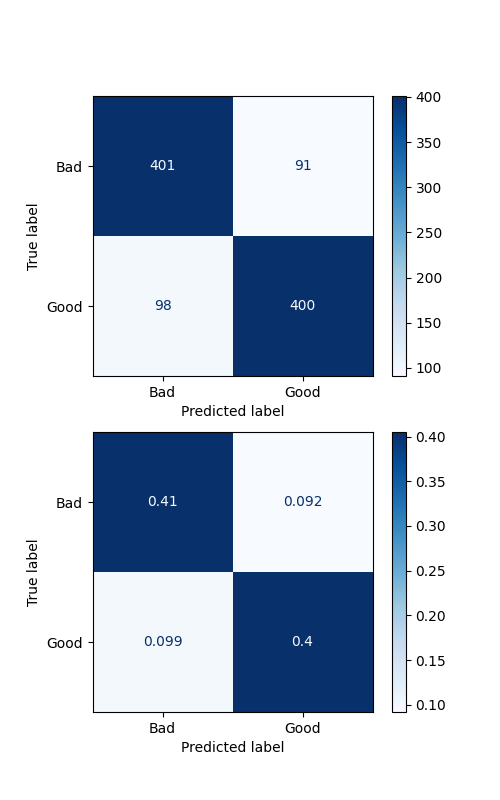

Precision = 0.81, Recall = 0.81, F1 = 0.81, Acc. = 0.81, Bal Acc. = 0.81


In [140]:
mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid,scoring='accuracy', cv=5, verbose=0, n_jobs=-1, refit=True)
gs_mnb = gs_mnb.fit(train_corpus, train_label_names)
_ = model_eval(test_label_names, test_corpus, model=gs_mnb.best_estimator_, plot_matrix = True, scoring_strategy='micro')

In [139]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
0,1,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 1)}",NaN,NaN
1,2,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",NaN,NaN
2,3,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 3)}",NaN,NaN
3,4,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 1)}",NaN,NaN
4,5,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 2)}",NaN,NaN
5,6,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 3)}",NaN,NaN
6,7,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 1)}",NaN,NaN
7,8,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}",NaN,NaN
8,9,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 3)}",NaN,NaN
9,10,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}",NaN,NaN


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(cv_train_features, train_label_names)
lr_bow_cv_scores = cross_val_score(lr, cv_train_features, train_label_names, cv=5)
lr_bow_cv_mean_score = np.mean(lr_bow_cv_scores)
print('CV Accuracy (5-fold):', lr_bow_cv_scores)
print('Mean CV Accuracy:', lr_bow_cv_mean_score)
lr_bow_test_score = lr.score(cv_test_features, test_label_names)
print('Test Accuracy:', lr_bow_test_score)

CV Accuracy (5-fold): [0.81343284 0.80348259 0.78855721 0.79551122 0.7755611 ]
Mean CV Accuracy: 0.7953089912035831
Test Accuracy: 0.805050505050505


In [11]:
from sklearn.svm import LinearSVC

svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(cv_train_features, train_label_names)
svm_bow_cv_scores = cross_val_score(svm, cv_train_features, train_label_names, cv=5)
svm_bow_cv_mean_score = np.mean(svm_bow_cv_scores)
print('CV Accuracy (5-fold):', svm_bow_cv_scores)
print('Mean CV Accuracy:', svm_bow_cv_mean_score)
svm_bow_test_score = svm.score(cv_test_features, test_label_names)
print('Test Accuracy:', svm_bow_test_score)

CV Accuracy (5-fold): [0.7960199  0.79104478 0.82089552 0.79052369 0.78802993]
Mean CV Accuracy: 0.7973027629930151
Test Accuracy: 0.7909090909090909


In [12]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
svm_sgd.fit(cv_train_features, train_label_names)
svmsgd_bow_cv_scores = cross_val_score(svm_sgd, cv_train_features, train_label_names, cv=5)
svmsgd_bow_cv_mean_score = np.mean(svmsgd_bow_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_bow_cv_scores)
print('Mean CV Accuracy:', svmsgd_bow_cv_mean_score)
svmsgd_bow_test_score = svm_sgd.score(cv_test_features, test_label_names)
print('Test Accuracy:', svmsgd_bow_test_score)

CV Accuracy (5-fold): [0.78855721 0.76368159 0.76616915 0.76558603 0.75561097]
Mean CV Accuracy: 0.7679209935360604
Test Accuracy: 0.7717171717171717


In [13]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(cv_train_features, train_label_names)
rfc_bow_cv_scores = cross_val_score(rfc, cv_train_features, train_label_names, cv=5)
rfc_bow_cv_mean_score = np.mean(rfc_bow_cv_scores)
print('CV Accuracy (5-fold):', rfc_bow_cv_scores)
print('Mean CV Accuracy:', rfc_bow_cv_mean_score)
rfc_bow_test_score = rfc.score(cv_test_features, test_label_names)
print('Test Accuracy:', rfc_bow_test_score)

CV Accuracy (5-fold): [0.79850746 0.77860697 0.75870647 0.75561097 0.74812968]
Mean CV Accuracy: 0.7679123087802882
Test Accuracy: 0.7767676767676768


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(cv_train_features, train_label_names)
gbc_bow_cv_scores = cross_val_score(gbc, cv_train_features, train_label_names, cv=5)
gbc_bow_cv_mean_score = np.mean(gbc_bow_cv_scores)
print('CV Accuracy (5-fold):', gbc_bow_cv_scores)
print('Mean CV Accuracy:', gbc_bow_cv_mean_score)
gbc_bow_test_score = gbc.score(cv_test_features, test_label_names)
print('Test Accuracy:', gbc_bow_test_score)

CV Accuracy (5-fold): [0.63681592 0.63681592 0.64427861 0.6234414  0.63341646]
Mean CV Accuracy: 0.6349536606245579
Test Accuracy: 0.6353535353535353


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)

In [16]:
# transform test articles into features
tv_test_features = tv.transform(test_corpus)

In [17]:
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (2008, 3665)  Test features shape: (990, 3665)


In [18]:
mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, train_label_names)
mnb_tfidf_cv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv=5)
mnb_tfidf_cv_mean_score = np.mean(mnb_tfidf_cv_scores)
print('CV Accuracy (5-fold):', mnb_tfidf_cv_scores)
print('Mean CV Accuracy:', mnb_tfidf_cv_mean_score)
mnb_tfidf_test_score = mnb.score(tv_test_features, test_label_names)
print('Test Accuracy:', mnb_tfidf_test_score)

CV Accuracy (5-fold): [0.79850746 0.79104478 0.79850746 0.78802993 0.77057357]
Mean CV Accuracy: 0.7893326385528716
Test Accuracy: 0.797979797979798


In [19]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(tv_train_features, train_label_names)
lr_tfidf_cv_scores = cross_val_score(lr, tv_train_features, train_label_names, cv=5)
lr_tfidf_cv_mean_score = np.mean(lr_tfidf_cv_scores)
print('CV Accuracy (5-fold):', lr_tfidf_cv_scores)
print('Mean CV Accuracy:', lr_tfidf_cv_mean_score)
lr_tfidf_test_score = lr.score(tv_test_features, test_label_names)
print('Test Accuracy:', lr_tfidf_test_score)

CV Accuracy (5-fold): [0.81343284 0.79850746 0.80597015 0.80548628 0.76309227]
Mean CV Accuracy: 0.7972978002754308
Test Accuracy: 0.806060606060606


In [20]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(tv_train_features, train_label_names)
svm_tfidf_cv_scores = cross_val_score(svm, tv_train_features, train_label_names, cv=5)
svm_tfidf_cv_mean_score = np.mean(svm_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svm_tfidf_cv_scores)
print('Mean CV Accuracy:', svm_tfidf_cv_mean_score)
svm_tfidf_test_score = svm.score(tv_test_features, test_label_names)
print('Test Accuracy:', svm_tfidf_test_score)

CV Accuracy (5-fold): [0.81343284 0.80845771 0.81094527 0.80548628 0.79551122]
Mean CV Accuracy: 0.8067666654259872
Test Accuracy: 0.8101010101010101


In [21]:
svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
svm_sgd.fit(tv_train_features, train_label_names)
svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd, tv_train_features, train_label_names, cv=5)
svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_tfidf_cv_scores)
print('Mean CV Accuracy:', svmsgd_tfidf_cv_mean_score)
svmsgd_tfidf_test_score = svm_sgd.score(tv_test_features, test_label_names)
print('Test Accuracy:', svmsgd_tfidf_test_score)

CV Accuracy (5-fold): [0.79104478 0.78358209 0.80348259 0.78553616 0.7680798 ]
Mean CV Accuracy: 0.7863450825672138
Test Accuracy: 0.7898989898989899


In [22]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(tv_train_features, train_label_names)
rfc_tfidf_cv_scores = cross_val_score(rfc, tv_train_features, train_label_names, cv=5)
rfc_tfidf_cv_mean_score = np.mean(rfc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', rfc_tfidf_cv_scores)
print('Mean CV Accuracy:', rfc_tfidf_cv_mean_score)
rfc_tfidf_test_score = rfc.score(tv_test_features, test_label_names)
print('Test Accuracy:', rfc_tfidf_test_score)

CV Accuracy (5-fold): [0.78606965 0.76119403 0.76368159 0.7755611  0.76558603]
Mean CV Accuracy: 0.7704184811602834
Test Accuracy: 0.7575757575757576


In [23]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_names)
gbc_tfidf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_names, cv=5)
gbc_tfidf_cv_mean_score = np.mean(gbc_tfidf_cv_scores)
print('CV Accuracy (5-fold):', gbc_tfidf_cv_scores)
print('Mean CV Accuracy:', gbc_tfidf_cv_mean_score)
gbc_tfidf_test_score = gbc.score(tv_test_features, test_label_names)
print('Test Accuracy:', gbc_tfidf_test_score)

CV Accuracy (5-fold): [0.63681592 0.6318408  0.64925373 0.62593516 0.64089776]
Mean CV Accuracy: 0.636948673093386
Test Accuracy: 0.6383838383838384


In [24]:
pd.DataFrame([['Naive Bayes', mnb_bow_cv_mean_score, mnb_bow_test_score, 
               mnb_tfidf_cv_mean_score, mnb_tfidf_test_score],
              ['Logistic Regression', lr_bow_cv_mean_score, lr_bow_test_score, 
               lr_tfidf_cv_mean_score, lr_tfidf_test_score],
              ['Linear SVM', svm_bow_cv_mean_score, svm_bow_test_score, 
               svm_tfidf_cv_mean_score, svm_tfidf_test_score],
              ['Linear SVM (SGD)', svmsgd_bow_cv_mean_score, svmsgd_bow_test_score, 
               svmsgd_tfidf_cv_mean_score, svmsgd_tfidf_test_score],
              ['Random Forest', rfc_bow_cv_mean_score, rfc_bow_test_score, 
               rfc_tfidf_cv_mean_score, rfc_tfidf_test_score],
              ['Gradient Boosted Machines', gbc_bow_cv_mean_score, gbc_bow_test_score, 
               gbc_tfidf_cv_mean_score, gbc_tfidf_test_score]],
             columns=['Model', 'CV Score (TF)', 'Test Score (TF)', 'CV Score (TF-IDF)', 'Test Score (TF-IDF)'],
             ).T

,0,1,2,3,4,5
Model,Naive Bayes,Logistic Regression,Linear SVM,Linear SVM (SGD),Random Forest,Gradient Boosted Machines
CV Score (TF),0.791329,0.795309,0.797303,0.767921,0.767912,0.634954
Test Score (TF),0.811111,0.805051,0.790909,0.771717,0.776768,0.635354
CV Score (TF-IDF),0.789333,0.797298,0.806767,0.786345,0.770418,0.636949
Test Score (TF-IDF),0.79798,0.806061,0.810101,0.789899,0.757576,0.638384


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, verbose=2)
gs_mnb = gs_mnb.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........mnb__alpha=1e-05, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .......mnb__alpha=0.0001, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .......mnb__alpha=0.0001, tfidf__ngram_

In [26]:
gs_mnb.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('mnb', MultinomialNB(alpha=1))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'mnb': MultinomialNB(alpha=1),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'mnb__alpha': 1,
 'mnb__class_prior': None,
 'mnb__fit_prior': True}

In [27]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
9,1,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)}",0.803760,0.024925
7,2,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}",0.793309,0.020531
8,3,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 1)}",0.791320,0.013353
5,4,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}",0.778877,0.011434
3,5,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 2)}",0.768918,0.009387
1,6,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.767426,0.008246
6,7,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}",0.766928,0.006912
4,8,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 1)}",0.745509,0.013274
2,9,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 1)}",0.740031,0.011409
0,10,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 1)}",0.738038,0.012240


In [28]:
best_mnb_test_score = gs_mnb.score(test_corpus, test_label_names)
print('Test Accuracy :', best_mnb_test_score)

Test Accuracy : 0.8181818181818182


In [29]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2)
gs_lr = gs_lr.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .................lr__C=1, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .................lr__C=5, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .................lr__C=5, tfidf__ngram_r

In [31]:
gs_lr.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(C=10, random_state=42))])

In [32]:
best_lr_test_score = gs_lr.score(test_corpus, test_label_names)
print('Test Accuracy :', best_lr_test_score)

Test Accuracy : 0.8191919191919191


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, verbose=2)
gs_svm = gs_svm.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END .............svm__C=0.01, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ..............svm__C=0.1, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ..............svm__C=0.1, tfidf__ngram_r

In [34]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('svm', LinearSVC(C=5, random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': LinearSVC(C=5, random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 5,
 'svm__class_weight': None,
 'svm__dual': True,
 'svm__fit_intercept': True,
 'svm__intercept_scaling': 1,
 'svm__loss': 'squared_hinge',
 'svm__max_iter'

In [35]:
best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print('Test Accuracy :', best_svm_test_score)

Test Accuracy : 0.8303030303030303


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('sgd', SGDClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

gs_sgd = GridSearchCV(sgd_pipeline, param_grid, cv=5, verbose=2)
gs_sgd = gs_sgd.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........sgd__alpha=1e-07, tfidf__ngram_range=(1, 2); total time=   0.0s
[CV] END ........sgd__alpha=1e-06, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END ........sgd__alpha=1e-06, tfidf__ngram_r

In [37]:
gs_sgd.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
  ('sgd', SGDClassifier(random_state=42))],
 'verbose': False,
 'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'sgd': SGDClassifier(random_state=42),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'sgd__alpha': 0.0001,
 'sgd__average': False,
 'sgd__class_weight': None,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0,
 'sgd__fit_intercept': 

In [51]:
best_sgd_test_score = gs_sgd.score(test_corpus, test_label_names)
print('Test Accuracy :', best_sgd_test_score)
sgd_predictions = gs_mnb.predict(test_corpus)
meu.get_metrics(true_labels=test_label_names, predicted_labels=sgd_predictions)

# inspect worng predicted
# print(np.where(sgd_predictions!=test_label_names))
idx_wrong = np.where(sgd_predictions!=test_label_names)
pd.DataFrame(list(zip(test_corpus[idx_wrong],test_label_names[idx_wrong],sgd_predictions[idx_wrong])))

Test Accuracy : 0.8303030303030303
Accuracy: 0.8182
Precision: 0.8183
Recall: 0.8182
F1 Score: 0.8182


,0,1,2
0,realli love stori line poler bear wa kinda cute anyon ha question fort steele ask away,Good,Bad
1,good protect doe not make phone bulky,Good,Bad
2,thi place two thumb way,Good,Bad
3,no complaints,Good,Bad
4,talk great custom servic cours back,Good,Bad
...,...,...,...
175,owner realli realli need quit soooooo cheap let wrap freak sandwich two paper not one,Bad,Good
176,wouldnt see thi movi free,Bad,Good
177,thi wa first time cannot wait next,Good,Bad
178,mains also uninspired,Bad,Good


In [39]:
import model_evaluation_utils as meu

In [40]:
mnb_predictions = gs_mnb.predict(test_corpus)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=mnb_predictions)

Accuracy: 0.8182
Precision: 0.8183
Recall: 0.8182
F1 Score: 0.8182


In [41]:
meu.display_classification_report(true_labels=test_label_names, 
                                  predicted_labels=mnb_predictions, classes=unique_classes)

              precision    recall  f1-score   support

        Good       0.83      0.81      0.82       498
         Bad       0.81      0.83      0.82       492

    accuracy                           0.82       990
   macro avg       0.82      0.82      0.82       990
weighted avg       0.82      0.82      0.82       990



In [42]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

NameError: name 'data_labels_map' is not defined

In [ ]:
unique_class_nums = label_map_df['Label Number'].values
mnb_prediction_class_nums = [label_data_map[item] for item in mnb_predictions]
meu.display_confusion_matrix_pretty(true_labels=test_label_nums, 
                                   predicted_labels=mnb_prediction_class_nums, classes=unique_class_nums)

In [ ]:
unique_classes = label_map_df['Label Name'].values
meu.display_confusion_matrix_pretty(true_labels=test_label_names, 
                                    predicted_labels=mnb_predictions, classes=unique_classes)

In [ ]:
label_map_df[label_map_df['Label Number'].isin([0, 15, 19])]

In [ ]:
train_idx, test_idx = train_test_split(np.array(range(len(data_df['Article']))), test_size=0.33, random_state=42)
test_idx

In [ ]:
predict_probas = gs_mnb.predict_proba(test_corpus).max(axis=1)
test_df = data_df.iloc[test_idx]
test_df['Predicted Name'] = mnb_predictions
test_df['Predicted Confidence'] = predict_probas
test_df.head()

In [ ]:
pd.set_option('display.max_colwidth', 200)
res_df = (test_df[(test_df['Target Name'] == 'talk.religion.misc') & (test_df['Predicted Name'] == 'soc.religion.christian')]
       .sort_values(by=['Predicted Confidence'], ascending=False).head(5))
res_df

In [ ]:
pd.set_option('display.max_colwidth', 200)
res_df = (test_df[(test_df['Target Name'] == 'talk.religion.misc') & (test_df['Predicted Name'] == 'alt.atheism')]
       .sort_values(by=['Predicted Confidence'], ascending=False).head(5))
res_df